In [1]:
from utils.datasets import get_code_alpaca_20k
from human_eval.data import read_problems as read_problems_human_eval

In [2]:
base_dataset = get_code_alpaca_20k()
#tokenized_dataset = base_dataset.map(tokenize_function, batched=True)
#tokenized_dataset = tokenized_dataset.with_format("torch")

In [3]:
base_dataset

DatasetDict({
    train: Dataset({
        features: ['output', 'input', 'instruction', 'code', 'prompt', 'completion'],
        num_rows: 3204
    })
})

In [4]:
base_dataset["train"][0]

{'output': 'def replace(self, replace_with):\n    new_string = ""\n    for char in self:\n        if char == " ":\n            new_string += replace_with\n        else:\n            new_string += char\n    return new_string',
 'input': 'string = "Hello World!"\nreplace_with = "Greetings!"',
 'instruction': 'Write a replace method for a string class which replaces the given string with a given set of characters.',
 'code': 'def replace(self, replace_with):\n    """ Write a replace method for a string class which replaces the given string with\n    a given set of characters.\n    """\n    new_string = ""\n    for char in self:\n        if char == " ":\n            new_string += replace_with\n        else:\n            new_string += char\n    return new_string\n',
 'prompt': 'def replace(self, replace_with):\n    """ Write a replace method for a string class which replaces the given string with\n    a given set of characters.\n    """',
 'completion': '    new_string = ""\n    for char in

In [5]:
he_problems = read_problems_human_eval()
print(f"Loaded {len(he_problems)} problems from human eval dataset")

Loaded 164 problems from human eval dataset


In [6]:
he_problems['HumanEval/0']

{'task_id': 'HumanEval/0',
 'prompt': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
 'entry_point': 'has_close_elements',
 'canonical_solution': '    for idx, elem in enumerate(numbers):\n        for idx2, elem2 in enumerate(numbers):\n            if idx != idx2:\n                distance = abs(elem - elem2)\n                if distance < threshold:\n                    return True\n\n    return False\n',
 'test': "\n\nMETADATA = {\n    'author': 'jt',\n    'dataset': 'test'\n}\n\n\ndef check(candidate):\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n    assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n    assert candidate([1.0, 2.0, 5.9,

In [7]:
print(he_problems['HumanEval/0']['prompt'])

from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



--------

# Generating the stats

In [8]:
from transformers import AutoTokenizer
model_name = "Qwen/Qwen1.5-0.5B-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# Iterate over the base_dataset and print the first 5 examples
stats = {
    "code_alpaca": {
        "prompt_counts": [],
        "completion_counts": [],
    },
    "human_eval": {
        "prompt_counts": [],
        "completion_counts": [],
    },
}

In [10]:
for example in base_dataset["train"]:
    stats["code_alpaca"]["prompt_counts"].append(len(
        tokenizer(example["prompt"])["input_ids"]
    ))
    stats["code_alpaca"]["completion_counts"].append(len(
        tokenizer(example["completion"])["input_ids"]
    ))

In [11]:
for _, example in he_problems.items():
    stats["human_eval"]["prompt_counts"].append(len(
        tokenizer(example["prompt"])["input_ids"]
    ))
    stats["human_eval"]["completion_counts"].append(len(
        tokenizer(example["canonical_solution"])["input_ids"]
    ))

# Plot the histograms

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.despine()

<Figure size 640x480 with 0 Axes>

In [14]:
# remove outliers: some values for completion counts for Code Alpaca greater than 1000
stats["code_alpaca"]["completion_counts"] = [x for x in stats["code_alpaca"]["completion_counts"] if x < 1000]

<Figure size 640x480 with 0 Axes>

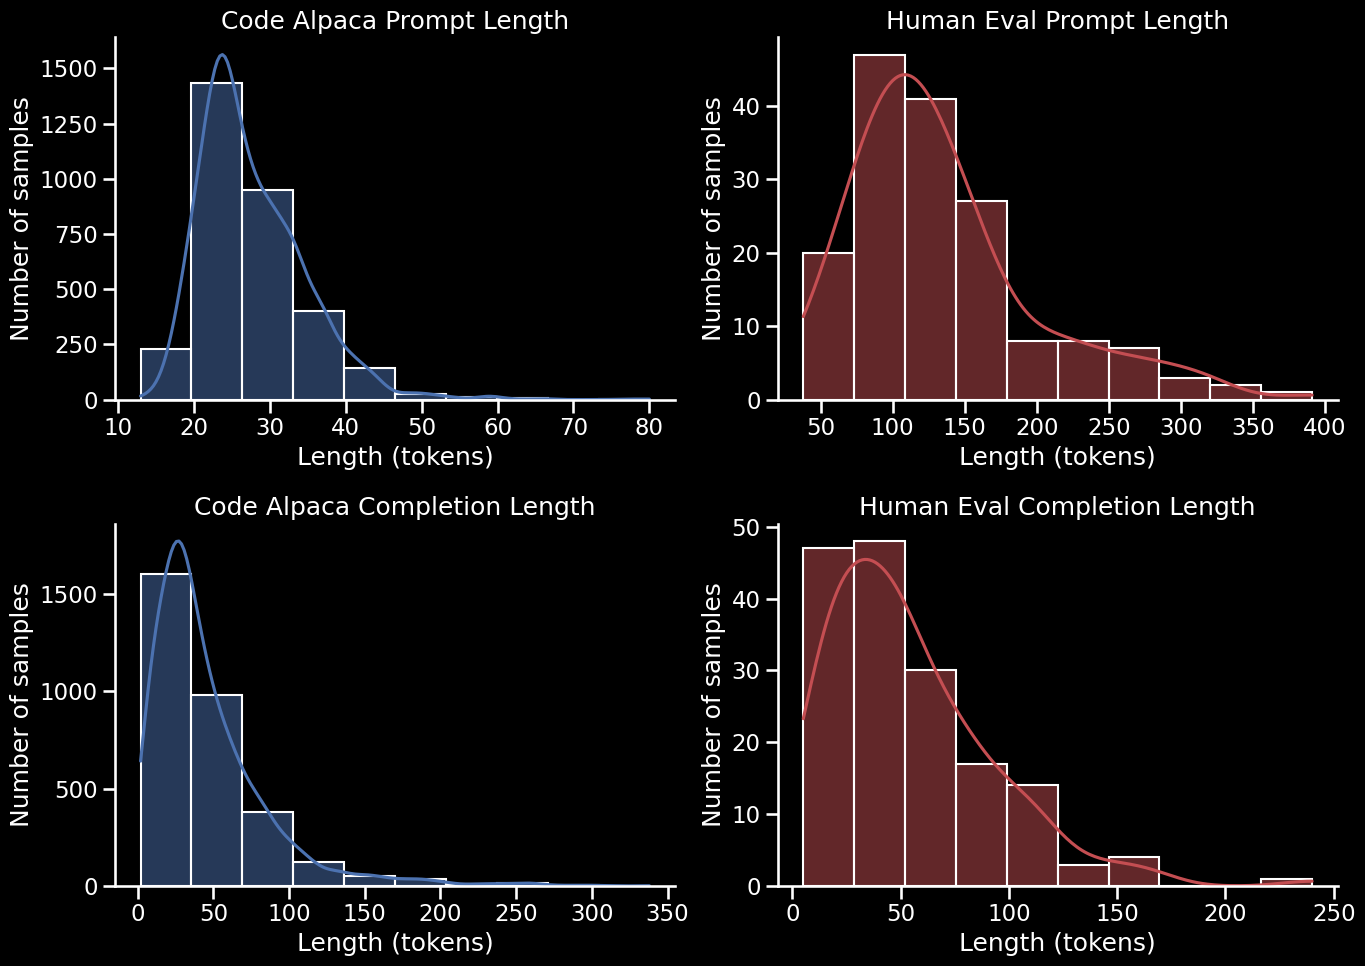

In [17]:
# Extract data
code_alpaca_prompts = stats["code_alpaca"]["prompt_counts"]
code_alpaca_completions = stats["code_alpaca"]["completion_counts"]
human_eval_prompts = stats["human_eval"]["prompt_counts"]
human_eval_completions = stats["human_eval"]["completion_counts"]

plt.tight_layout()
plt.show()

# Create histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for code_alpaca prompt counts
sns.histplot(code_alpaca_prompts, bins=10, kde=True, ax=axes[0, 0], color='b')
axes[0, 0].set_title('Code Alpaca Prompt Length')
axes[0, 0].set_xlabel('Length (tokens)')  # Set x-axis label
axes[0, 0].set_ylabel('Number of samples')        # Set y-axis label

# Histogram for human_eval prompt counts
sns.histplot(human_eval_prompts, bins=10, kde=True, ax=axes[0, 1], color='r')
axes[0, 1].set_title('Human Eval Prompt Length')
axes[0, 1].set_xlabel('Length (tokens)')  # Set x-axis label
axes[0, 1].set_ylabel('Number of samples')        # Set y-axis label

# Histogram for code_alpaca completion counts
sns.histplot(code_alpaca_completions, bins=10, kde=True, ax=axes[1, 0], color='b')
axes[1, 0].set_title('Code Alpaca Completion Length')
axes[1, 0].set_xlabel('Length (tokens)')  # Set x-axis label
axes[1, 0].set_ylabel('Number of samples')        # Set y-axis label

# Histogram for human_eval completion counts
sns.histplot(human_eval_completions, bins=10, kde=True, ax=axes[1, 1], color='r')
axes[1, 1].set_title('Human Eval Completion Length')
axes[1, 1].set_xlabel('Length (tokens)')  # Set x-axis label
axes[1, 1].set_ylabel('Number of samples')        # Set y-axis label

sns.despine()

plt.tight_layout()
#fig.savefig('token_distribution.png', dpi=250, transparent=True)
fig.savefig('token_distribution.jpg', dpi=250, transparent=False)

plt.show()